In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
jobs_train = pd.read_csv('dataset/train_set.csv')
jobs_train

,Job_offer,Label
0,"Openjobmetis SpA ricerca, per importante azien...",Java Developer
1,"La persona prescelta, diplomata o laureata in ...",Software Engineer
2,Sei un informatico o matematico con la passion...,Software Engineer
3,"Ti occuperai della progettazione, realizzazion...",Programmer
4,Stiamo cercando uno\una sviluppatore\sviluppat...,Programmer
...,...,...
1747,"* Test JUnit\n * Git, La Ibs Srl è alla ri...",Java Developer
1748,"La ricorsa, inserita all'interno di un team, l...",Programmer
1749,Sviluppatore Java Junior da inserire in attivi...,Java Developer
1750,La risorsa sarà inserita nei team di risorse d...,Web Developer


In [3]:
jobs_train.dtypes

Job_offer    object
Label        object
dtype: object

### Let's have a look at data distribution.

<AxesSubplot:title={'center':'Employees Categories Count'}>

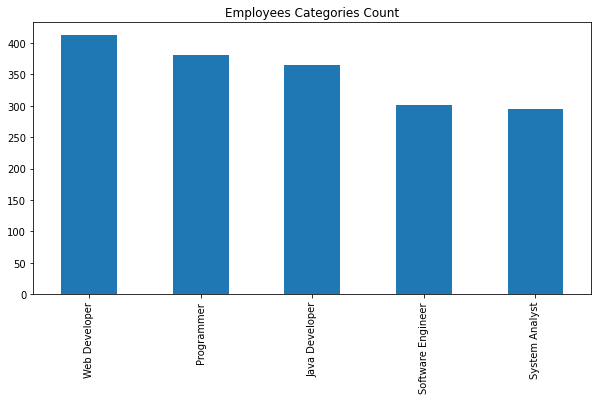

In [4]:
jobs_train['Label'].value_counts().plot(kind='bar',
                                   title='Employees Categories Count',
                                    figsize=(10,5))

In [5]:
jobs_train['Job_offer'].isnull().any()

False

## Text Preprocessing:
* first, we remove the punctuation, numbers, and stop words from each commit message.
* second, all the words are converted to lower case and then stemmed using the Porter Stemmer in the NLTK package. The goal of stemming is to reduce the number of inflectional forms of words appearing in the commit; it will cause words such as “performance” and “performing” to syntactically match one another by reducing them to their base word “perform”. This helps decrease the size of the vocabulary space and improve the volume of the feature space in the corpus.
* finally, each corpus is transformed into vector space model (VSM) using the tf-idf vectorizer in Python’s SKlearn package to extract the features.

In [6]:
import re

nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("italian")
jobs_train['Job_offer'] = jobs_train['Job_offer'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fabmoore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# X_train, X_val, y_train, y_val = train_test_split(np.array(jobs_train.Job_offer), np.array(jobs_train.Label), test_size=0.2, random_state=42)

In [8]:
X_train, y_train = np.array(jobs_train.Job_offer), np.array(jobs_train.Label)

In [9]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
# X_val_counts = count_vect.transform(X_val)
print(X_train_counts.shape)
# print(X_val_counts.shape)

(1752, 7760)


Transform a count matrix to a normalized tf or tf-idf representation.

Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [10]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_val_tfidf = tfidf_transformer.transform(X_val_counts)
print(X_train_tfidf.shape)
# print(X_val_tfidf.shape)

(1752, 7760)


## Classifier: SVC

In [11]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
clf = model.fit(X_train_tfidf, y_train)

### Take test dataset and manipulate it in the same way of training set.

In [12]:
jobs_test = pd.read_csv('dataset/test_set.csv')
jobs_test

,Job_offer,Label
0,Siamo alla ricerca di figure di Full Stack Dev...,Web Developer
1,"Nell'ambito del potenziamento della struttura,...",Java Developer
2,"* Gestione dell'infrastruttura informatica, de...",System Analyst
3,La risorsa è il responsabile dell'installazion...,System Analyst
4,"La risorsa, inserita nell'area Innovation Cent...",Java Developer
...,...,...
434,"Ali SpA filiale di Fano, cerca per Azienda di ...",System Analyst
435,Job summary Parola chiave: digitalizzazione! U...,Web Developer
436,Job summary Parola chiave: digitalizzazione! U...,Web Developer
437,Unazienda che offre servizi a 360°: alle grand...,Web Developer


In [13]:
jobs_test['Job_offer'] = jobs_test['Job_offer'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [14]:
X_test, y_test = np.array(jobs_test.Job_offer), np.array(jobs_test.Label)

### Perform tokenization and learn a vocabulary dictionary of all tokens.

In [15]:
X_test_counts = count_vect.transform(X_test)

In [16]:
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

### Perform predictions on test data.

In [17]:
predicted = clf.predict(X_test_tfidf)

### Compute accuracy.

In [18]:
accuracy = 0
for prediction,correct in zip(predicted, y_test):
    if prediction == correct:
        accuracy += 1
accuracy/len(predicted)

0.8109339407744874

In [19]:
final_df = pd.DataFrame()
final_df[['Job_description', 'Label_true']] = jobs_test[['Job_offer', 'Label']]
final_df['Label_pred'] = predicted.tolist()
final_df

,Job_description,Label_true,Label_pred
0,siamo ricerca figur full stack develop inserir...,Web Developer,Web Developer
1,nell ambito potenziamento struttura seguendo c...,Java Developer,Java Developer
2,gestion infrastruttura informatica sistemi ope...,System Analyst,System Analyst
3,la risorsa responsabil installazion configuraz...,System Analyst,System Analyst
4,la risorsa inserita area innov center occup pr...,Java Developer,Java Developer
...,...,...,...
434,ali spa filial fano cerca azienda fano tecnico...,System Analyst,System Analyst
435,job summari parola chiav digitalizzazion uno p...,Web Developer,Web Developer
436,job summari parola chiav digitalizzazion uno p...,Web Developer,Web Developer
437,unazienda offr servizi grandi aziend settor ba...,Web Developer,Web Developer


In [20]:
print('Precision \t\t Recall \t\t F1-score')
precision_recall_fscore_support(final_df.Label_true, final_df.Label_pred, average='macro')

Precision 		 Recall 		 F1-score


(0.8136601721053903, 0.8144515262355068, 0.8130225868770342, None)

In [21]:
# save the model to disk
filename = "final_model.sav"
pickle.dump(clf, open(filename, 'wb'))

### To load the model from disk and evaluate the accuracy on the test set uncomment the lines below.

In [22]:
"""# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_tfidf, y_test)
print(result)"""

"# load the model from disk\nloaded_model = pickle.load(open(filename, 'rb'))\nresult = loaded_model.score(X_test_tfidf, y_test)\nprint(result)"

### Create output file with predictions on test set.

In [23]:
filename = 'output.csv'
final_df.to_csv(filename, sep=';')